# ML Final Project

This project aims to classify patients with different types of thyroid related disease given their age, sex, and medical information – including test results for thyroid hormone levels in blood. The data was obtained from [this UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/thyroid+disease). The repository contains several text files with different subsets of the data. One of them contains information for over 9000 unique patients along with a medical diagnosis out of 20 possible classes. Those classes make up 7 distinct diagnosis types:
- `hyperthyroid conditions`
- `hypothyroid conditions`
- `binding protein conditions`
- `non-thyroidal conditions`
- `replacement therapy`
- `discordant results`
- `negative diagnosis`

The different target diagnoses were mapped to one of these classes at the moment import to the notebook. Some inconclusive diagnoses were dropped given that they make up less than 3% of all cases present in the dataset.

#### Preliminary Thyroid Disease Research

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

# importing dataset from persistent landing
thyroidDF = pd.read_csv('data/all_thyroid.csv') # thyroidDF.csv
thyroidDF_test = pd.read_csv('data/all_thyroid_test.csv') # thyroidDF.csv

thyroidDF = thyroidDF.append(thyroidDF_test, ignore_index=True)

# dropping redundant attributes from thyroidDF dataset
thyroidDF.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

# unifying targets
thyroidDF['target'] = np.nan
thyroidDF['target'] = np.where((thyroidDF.target_hyper == 'negative') & (thyroidDF.target_hypo == 'negative'), 'negative', thyroidDF.target)
thyroidDF['target'] = np.where((thyroidDF.target_hyper == 'negative') & (thyroidDF.target_hypo != 'negative'), 'hypothyroid', thyroidDF.target)
thyroidDF['target'] = np.where((thyroidDF.target_hyper != 'negative') & (thyroidDF.target_hypo == 'negative'), 'hyperthyroid', thyroidDF.target)

# dropping old target columns
thyroidDF.drop(['target_hypo', 'target_hyper'], axis=1, inplace=True)

# dataset summary
thyroidDF.info()
thyroidDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3771 non-null   float64
 1   sex                  3622 non-null   object 
 2   on_thyroxine         3772 non-null   object 
 3   query_on_thyroxine   3772 non-null   object 
 4   on_antithyroid_meds  3772 non-null   object 
 5   sick                 3772 non-null   object 
 6   pregnant             3772 non-null   object 
 7   thyroid_surgery      3772 non-null   object 
 8   I131_treatment       3772 non-null   object 
 9   query_hypothyroid    3772 non-null   object 
 10  query_hyperthyroid   3772 non-null   object 
 11  lithium              3772 non-null   object 
 12  goitre               3772 non-null   object 
 13  tumor                3772 non-null   object 
 14  hypopituitary        3772 non-null   object 
 15  psych                3772 non-null   o

/var/folders/hd/rpm_8j3d44n1dqt00dv0sps00000gn/T/ipykernel_35079/3689051601.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thyroidDF = thyroidDF.append(thyroidDF_test, ignore_index=True)


,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


### Data Summary & Initial Thoughts

The columns listed below were removed because of redundacy. They are boolean and state whether or not a value has been recorded for their respective blood tests. If a value has been recorded for a blood test, it will be present in its column. Otherwise, it will be null.
- `TSH_measured`
- `T3_measured`
- `TT4_measured`
- `T4U_measured`
- `FTI_measured`
- `TBG_measured`

The `patient_id` attribute was also removed after checking for duplicate observations because it provides no use to us moving forward.

In [16]:
thyroidDF[thyroidDF.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
1364,455.0,F,f,f,f,f,f,f,f,f,...,f,f,f,1.1,2.0,118.0,1.13,104.0,NaN,negative


In [17]:
# changing age of observations with ('age' > 100) to null
thyroidDF['age'] = np.where((thyroidDF.age > 100), np.nan, thyroidDF.age) 

---
## Exploratory Data Analysis

<AxesSubplot:xlabel='target', ylabel='TBG'>

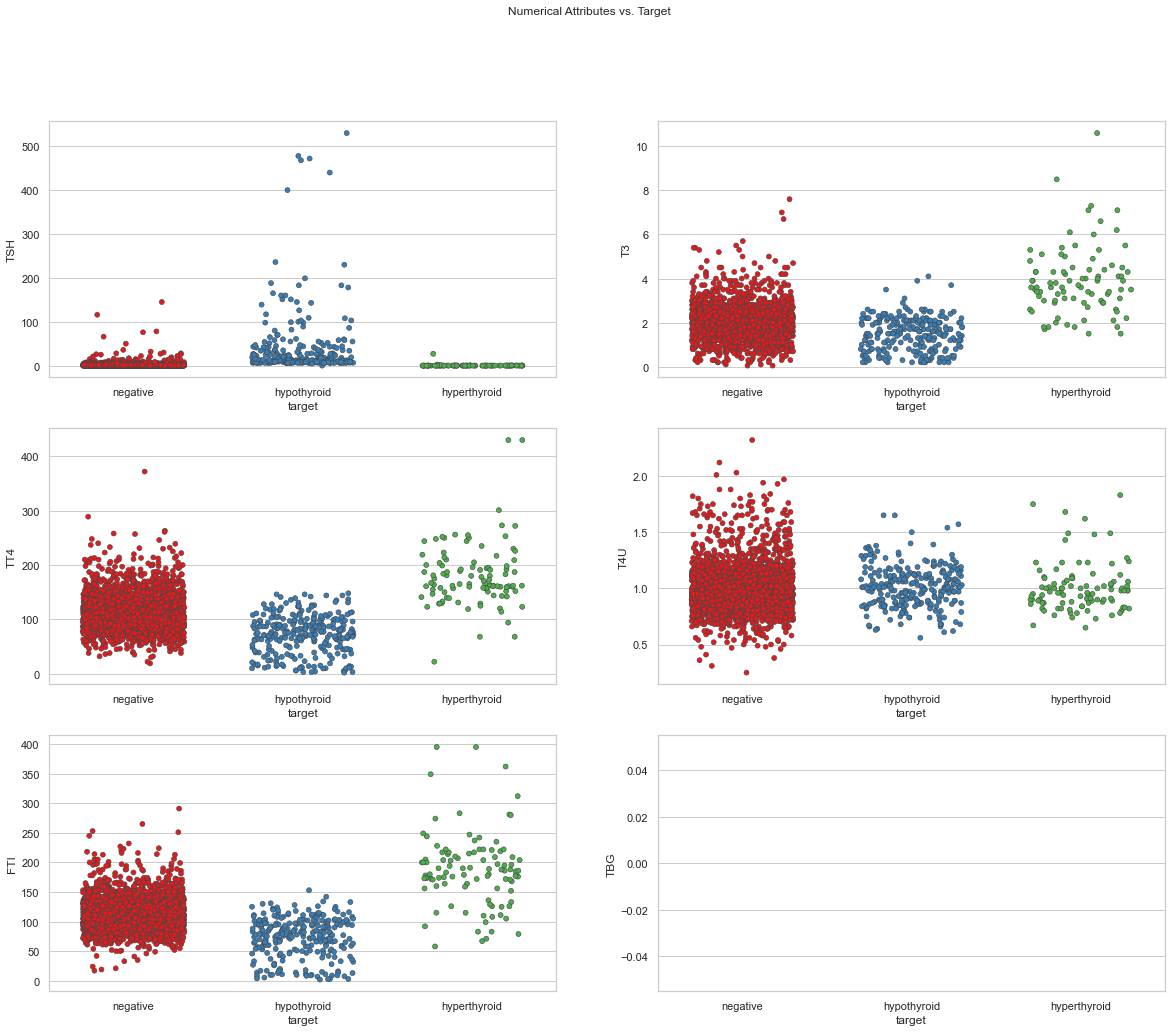

In [18]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_theme(style='ticks')

# TSH vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TSH, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T3, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TT4, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T4U, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.FTI, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TBG, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[2, 1])


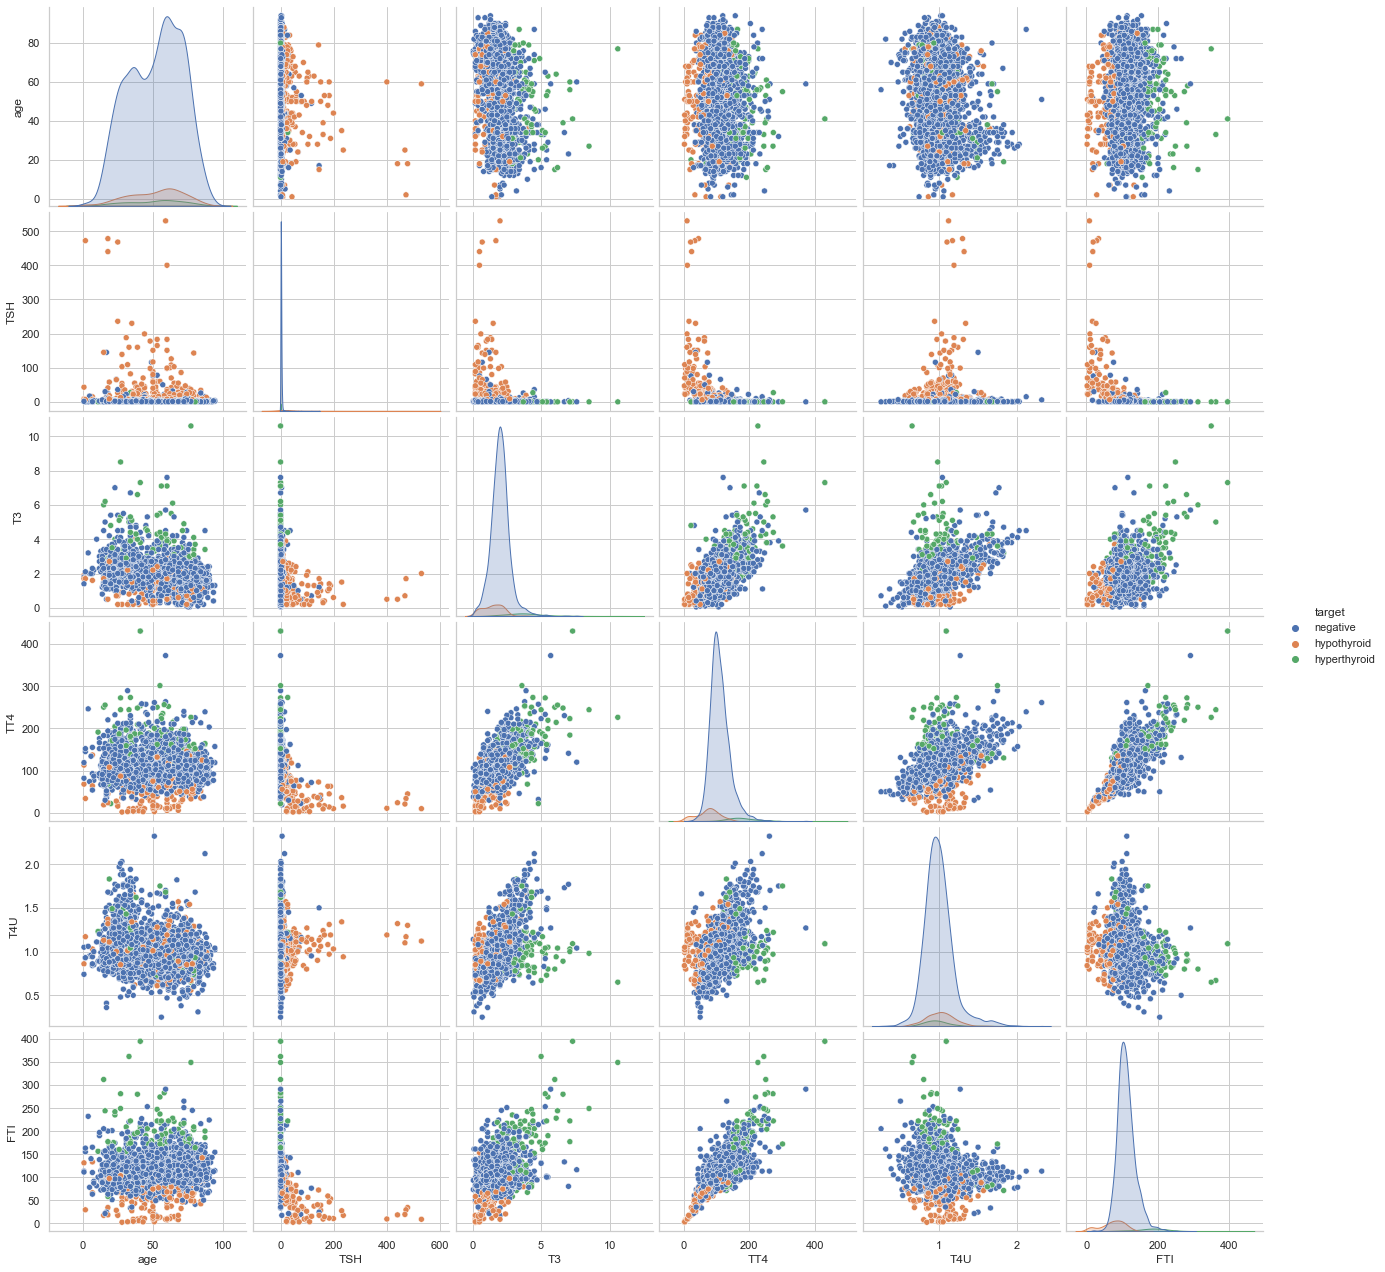

In [19]:
numericalDF = thyroidDF[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=3);
plt.show()

---
## Preprocessing

### Handling Missing Values

After doing a preliminary check...

In [20]:
# calculating missingess of entire DF
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Overall Missingness of thyroidDF is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(thyroidDF)

Overall Missingness of thyroidDF is: 7.52%


,Total,Percent
TBG,3772,1.000000
T3,769,0.203871
T4U,387,0.102598
FTI,385,0.102068
TSH,369,0.097826
TT4,231,0.061241
sex,150,0.039767
age,2,0.000530
goitre,0,0.000000
psych,0,0.000000


### Missing Table Summary

**thyroidDF[`'TBG'`]** – 97.03% missing
- The 'TBG' attribute is almost entirely missing from the dataset. This column will be removed at once!

**thyroidDF[`'age'`]** – 0.045% missing
- We will also go ahead and drop these 4 observations from the dataset. All 4 of these observations belong to observations with 'target' == 'negative'

**thyroidDF[`'Sex'`]** – 3.37% missing
- There are a total of 300 observations where 'sex' is null. In an attempt to preserve some of these values, we check how many of these observations also have 'pregnant' == True. There are 3 such observations. Assuming the 'pregnancy' attribute is correct for these observations, we can confidently say these 3 observations belong to women and can change their respective values.

In [21]:
# dropping 'TBG' attribute from dataset
thyroidDF.drop(['TBG'], axis=1, inplace=True)

# dropping 4 observations with abnormal 'age' from dataset
thyroidDF.dropna(subset=['age'], inplace=True)

# changing sex of observations with ('pregnant' == True) & ('sex' == null) to Female
thyroidDF['sex'] = np.where((thyroidDF.sex.isnull()) & (thyroidDF.pregnant == 't'), 'F', thyroidDF.sex)

In [22]:
# replacing boolean strings with binary 0 and 1
thyroidDF.replace('f', 0, inplace=True)
thyroidDF.replace('t', 1, inplace=True)

# replacing sex with binary 0 and 1
thyroidDF.replace('M', 0, inplace=True) # male mapped to 0
thyroidDF.replace('F', 1, inplace=True) # female mapped to 1

thyroidDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3770 entries, 0 to 3771
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3770 non-null   float64
 1   sex                  3622 non-null   float64
 2   on_thyroxine         3770 non-null   int64  
 3   query_on_thyroxine   3770 non-null   int64  
 4   on_antithyroid_meds  3770 non-null   int64  
 5   sick                 3770 non-null   int64  
 6   pregnant             3770 non-null   int64  
 7   thyroid_surgery      3770 non-null   int64  
 8   I131_treatment       3770 non-null   int64  
 9   query_hypothyroid    3770 non-null   int64  
 10  query_hyperthyroid   3770 non-null   int64  
 11  lithium              3770 non-null   int64  
 12  goitre               3770 non-null   int64  
 13  tumor                3770 non-null   int64  
 14  hypopituitary        3770 non-null   int64  
 15  psych                3770 non-null   i

<AxesSubplot:>

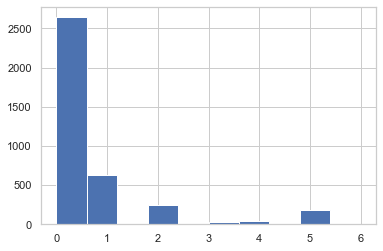

In [23]:
# count missing values per row
thyroidDF['n_missing'] = thyroidDF.isnull().sum(axis=1)
thyroidDF['n_missing'].hist()

In [24]:
# calculating missingess of entire DF
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Overall Missingness of thyroidDF is: {:.2f}%'.format(missingness * 100))

# remove rows with 3 or more missing values
thyroidDF.drop(thyroidDF.index[thyroidDF['n_missing'] > 2], inplace=True)
print
missing_table(thyroidDF)

Overall Missingness of thyroidDF is: 2.71%


,Total,Percent
T3,563,0.159898
TSH,154,0.043738
T4U,144,0.040897
FTI,142,0.040329
sex,122,0.034649
TT4,2,0.000568
age,0,0.000000
goitre,0,0.000000
target,0,0.000000
psych,0,0.000000


In [25]:
thyroidDF[thyroidDF.target != 'negative'].n_missing.value_counts()

0    292
1     69
2     24
Name: n_missing, dtype: int64

### Imputation with MICE
In order to impute missing data with MICE it must be Missing at Random (MAR)

In [26]:
thyroidDF.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,target,n_missing
0,41.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,1.30,2.5,125.0,1.14,109.0,negative,0
1,23.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,4.10,2.0,102.0,NaN,NaN,negative,2
2,46.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109.0,0.91,120.0,negative,1
3,70.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175.0,NaN,NaN,negative,2
4,70.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61.0,0.87,70.0,negative,0


In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# re-mapping target vaues to diagnostic groups
diagnoses = {'negative': 0,
                'hyperthyroid': 1, 
                'hypothyroid': 2}

mice_df = thyroidDF.copy()
mice_df['target'] = mice_df['target'].map(diagnoses) # re-mapping

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), max_iter=30, n_nearest_features=None, imputation_order='ascending')

mice_thyroidDF = pd.DataFrame(mice_imputer.fit_transform(mice_df), columns=mice_df.columns)

# re-mapping target vaues to diagnostic groups
diagnoses = {0: 'negative',
                1: 'hyperthyroid', 
                2: 'hypothyroid'}

mice_thyroidDF['target'] = mice_thyroidDF['target'].map(diagnoses) # re-mapping

<AxesSubplot:xlabel='target', ylabel='FTI'>

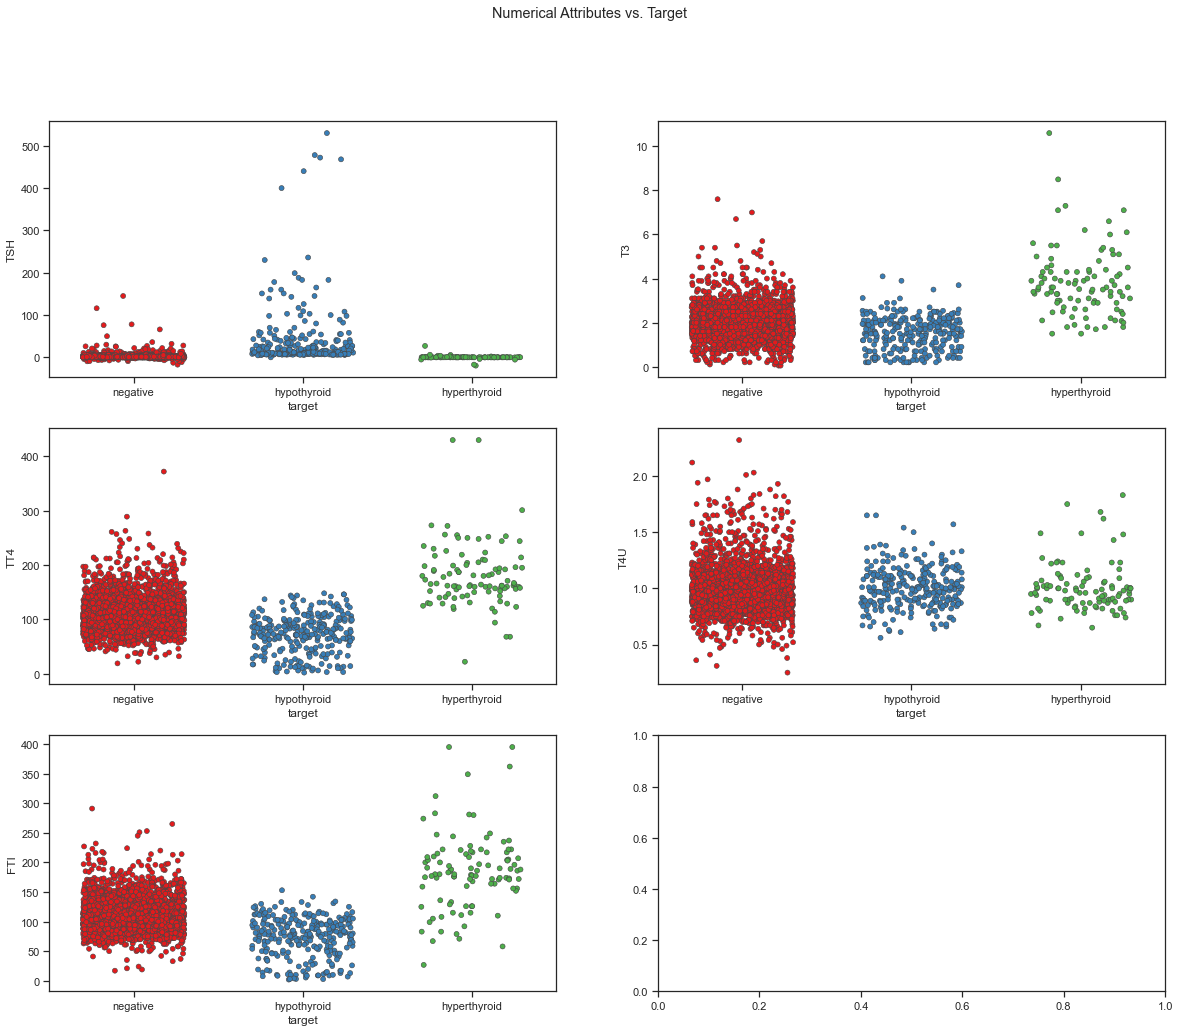

In [30]:
# Analyze missing data
missing_table(mice_thyroidDF)

# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_theme(style='ticks')

# TSH vs. 'target'
sns.stripplot(x=mice_thyroidDF.target, y=mice_thyroidDF.TSH, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=mice_thyroidDF.target, y=mice_thyroidDF.T3, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=mice_thyroidDF.target, y=mice_thyroidDF.TT4, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=mice_thyroidDF.target, y=mice_thyroidDF.T4U, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=mice_thyroidDF.target, y=mice_thyroidDF.FTI, palette='Set1', linewidth=0.6, jitter= 0.3, ax=axes[2, 0])

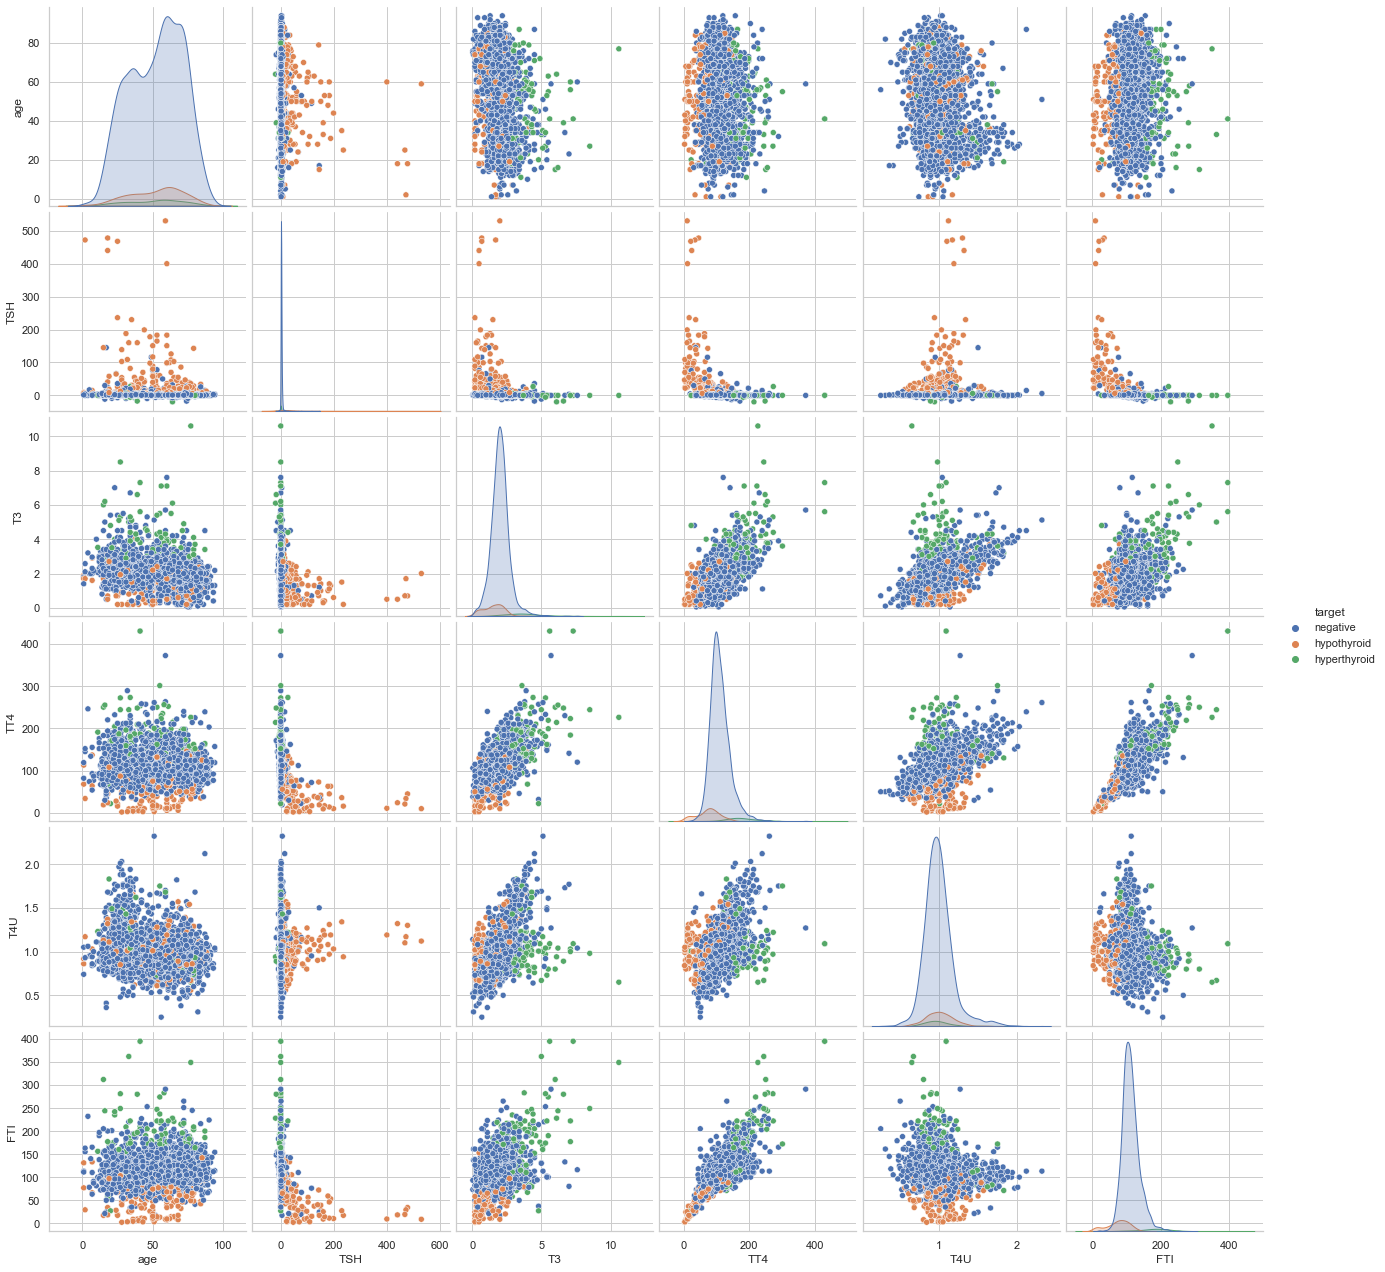

In [31]:
mice_numericalDF = mice_thyroidDF[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(mice_numericalDF, hue='target', height=3);
plt.show()

### Imputation with KNN

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Define scaler to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
knn_thyroidDF = pd.DataFrame(scaler.fit_transform(thyroidDF), columns = thyroidDF.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
knn_thyroidDF = pd.DataFrame(knn_imputer.fit_transform(knn_thyroidDF), columns=knn_thyroidDF.columns)


---

## KNN Classifier

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


knnDF = mice_thyroidDF.copy()

X = knnDF.drop('target', axis=1).copy()
y = knnDF['target'].copy()

MinMaxScaler = MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train,y_train)

y_pred = clf_knn.predict(X_test) # These are the predicted output values

result = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n')
print(result)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\nClassification Report: \n') 
print(classification_report(y_test, y_pred))

Confusion Matrix: 

[[  8   0  17]
 [  1  38  32]
 [ 11   4 770]]

Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.75
Macro Recall: 0.61
Macro F1-score: 0.66

Weighted Precision: 0.92
Weighted Recall: 0.93
Weighted F1-score: 0.92

Classification Report: 

              precision    recall  f1-score   support

hyperthyroid       0.40      0.32      0.36        25
 hypothyroid       0.90      0.54      0.67        71
    negative       0.94      0.98      0.96       785

    accuracy                           0.93       881
   macro avg       0.75      0.61      0.66       881
weighted avg       0.92      0.93      0.92       881



## SVC Classifier

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# SVC classifier base run
#svcDF = mice_thyroidDF.drop(mice_thyroidDF.index[(mice_thyroidDF['target'] != 'negative') & (mice_thyroidDF['target'] != 'hyper') & (mice_thyroidDF['target'] != 'hypo')])
svcDF = mice_thyroidDF.copy()

X = svcDF.drop('target', axis=1).copy()
y = svcDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

svc = SVC(kernel='rbf', C=1).fit(X_train, y_train)
y_pred = svc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[  2   0  23]
 [  0  27  44]
 [  1   2 782]]

Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.84
Macro Recall: 0.49
Macro F1-score: 0.55

Weighted Precision: 0.91
Weighted Recall: 0.92
Weighted F1-score: 0.90

Classification Report

              precision    recall  f1-score   support

hyperthyroid       0.67      0.08      0.14        25
 hypothyroid       0.93      0.38      0.54        71
    negative       0.92      1.00      0.96       785

    accuracy                           0.92       881
   macro avg       0.84      0.49      0.55       881
weighted avg       0.91      0.92      0.90       881



## XGBoost Classifier

In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, get_scorer_names

xgbDF = thyroidDF.replace(np.nan, 0)

# re-mapping target vaues to diagnostic groups
diagnoses = {'negative': 0,
                'hyper': 1, 
                'hypo': 2, 
                'binding': 3, 
                'other': 4,
                'rep': 5, 
                'discordant': 6}

xgbDF['target'] = xgbDF['target'].map(diagnoses) # re-mapping

# xgboost classifier base run
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

clf_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3, missing=None, seed=42)
clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric=['merror','mlogloss'],
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()


ValueError: Input y contains NaN.

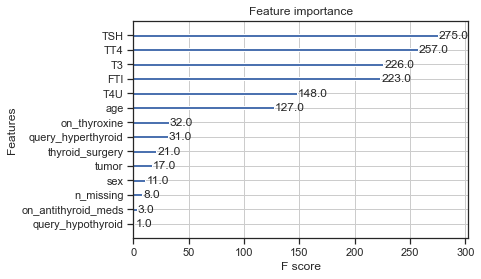

In [219]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(clf_xgb, ax=ax)
plt.show()

#### GridSearchCV Optimization for XGBoost Classifier

In [ ]:
## ROUND 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='multi:softmax', num_class=3, missing=None, seed=42),
    param_grid=param_grid,
    scoring='f1',
    verbose=0,
    n_jobs = 10,
    cv = 3
)

xgb_CV = optimal_params.fit(X_train, y_train)

for i in pd.DataFrame(xgb_CV.cv_results_).sort_values('rank_test_score')['params'].head():
    print(i)

[17:41:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-merror:0.01214	validation_0-mlogloss:0.95877	validation_1-merror:0.01456	validation_1-mlogloss:0.95945
[1]	validation_0-merror:0.01120	validation_0-mlogloss:0.84315	validation_1-merror:0.01512	validation_1-mlogloss:0.84468
[2]	validation_0-merror:0.01214	validation_0-mlogloss:0.74550	validation_1-merror:0.01456	validation_1-mlogloss:0.74756
[3]	validation_0-merror:0.01120	validation_0-mlogloss:0.66235	validation_1-merror:0.01512	validation_1-mlogloss:0.66509
[4]	validation_0-merror:0.01120	validation_0-mlogloss:0.59074	val

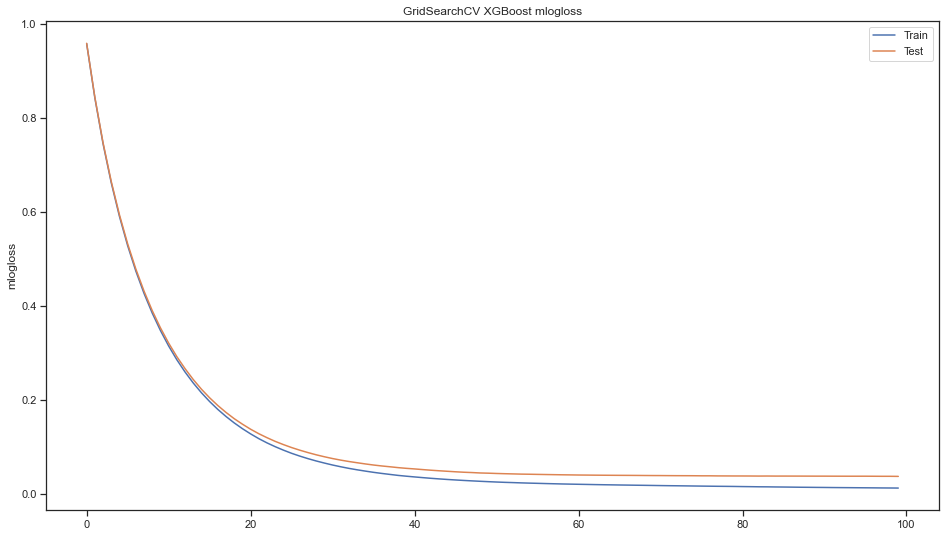

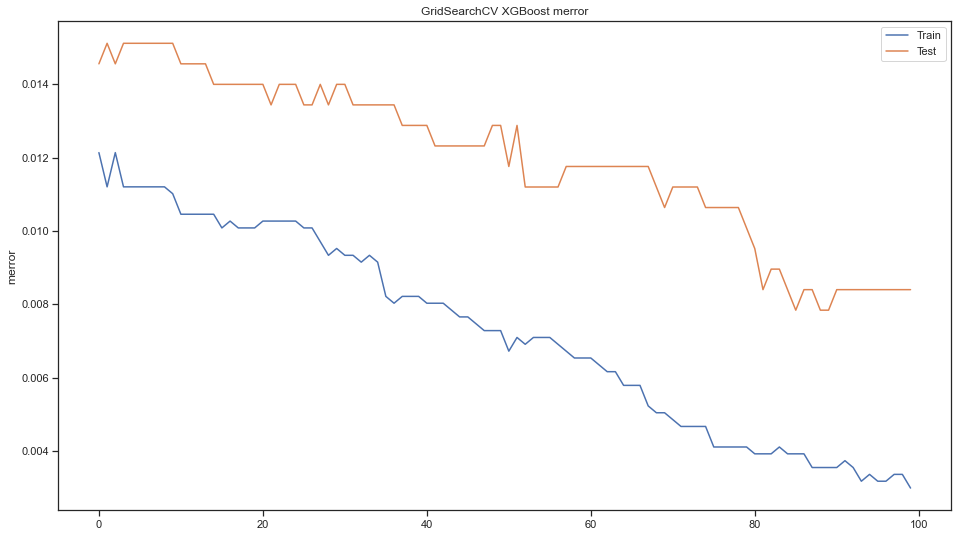

In [238]:
# xgboost classifier after GridSearchCV
scale_pos_weight = y_train[y_train == 0].count() / y_train[y_train != 0].count()

clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='multi:softmax', 
                        num_class=3, 
                        missing=None,
                        gamma=0,
                        learning_rate=0.1,
                        max_depth=3,
                        reg_lambda=0,
                        scale_pos_weight=scale_pos_weight)
clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric=['merror','mlogloss'],
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

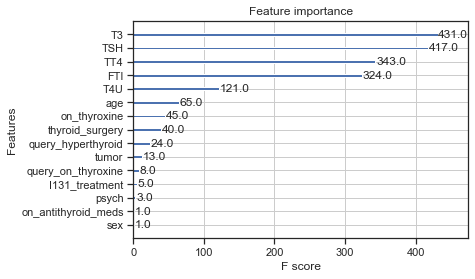

In [221]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(clf_xgb, ax=ax)
plt.show()